# [Solved] Lab 2: *Kernelized* machine learning

Advanced Topics in Machine Learning -- Spring 2024, UniTS

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/adv-ml-units/blob/main/solutions/AdvML_UniTS_2023_Lab_02_Kernel_ridge_regression_and_kPCA_Solved.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

### *Kernel Regression* and *Kernel Ridge Regression*

Recall that the solution of **linear regression** can also be written as: $w=(X^{T}X)^{-1}X^{T}y=X^{T}(XX^{T})^{-1}y$

Let $X\in R^{N\times d}$: we have $X^{T}X\in R^{d\times d}$ and $K=XX^{T}\in R^{N\times N}$. Whether it is more convenient to (pre)compute which matrix product (among $X^{T}X$, $XX^{T}$) depends on the $d/N$ ratio.

As far as predictions are concerned, we have that: $f(z)=z^{T}w=z^{T} X^{T}(XX^{T})^{-1}y= \alpha^{T}(z)K^{-1}y$, with $\alpha(z)=z^{T}X^{T}=K(z,X)\in R^{1\times N}$.

How can we move to the non-linear regression case?  We just substitute $x\rightarrow \phi(x)$, and the reasoning above can be repeated!

For more information, you can look up [this Medium article](https://knork.medium.com/linear-regression-in-python-from-scratch-with-kernels-e9c37f7975b9) or [this code-first tutorial](https://github.com/luigicarratino/Tutorial_Kernels_MLSS2019_London/blob/master/Tutorial%20Kernel.ipynb).

In [1]:
import numpy as np
from numpy import exp

from scipy import linalg as LA
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.decomposition import PCA

**Exercise 1: linear data regression**
1. Generate and plot a dataset consisting in $100$ datapoints in the form $(x_i,y_i)$. The $x_i$ are sampled uniformly in $[2,30]$, whereas the $y_i$ are sampled from a Gaussian distribution centred in $2x_i + 50$ having unit variance.

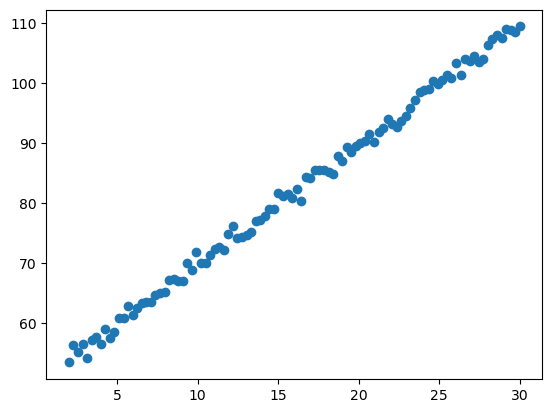

In [2]:
x = np.linspace(2, 30, 100)
y = 2 * x + 50 + np.random.normal(0, 1, x.shape[0])
_ = plt.plot(x, y, "o")

2. Fit a linear regression model to the data, **with no learnable intercept** (i.e. fix it to zero), and plot the predictions of the resulting model compared to the data.

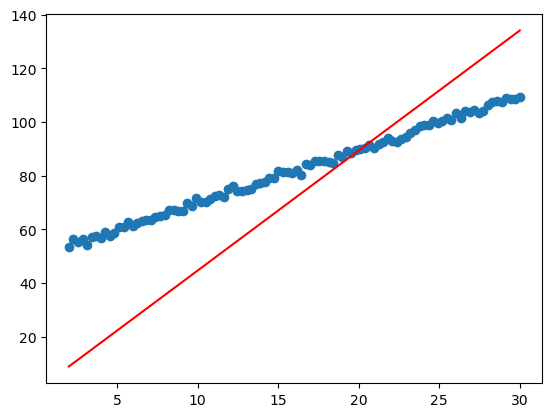

In [3]:
newx = x[:, np.newaxis]
k = np.linalg.inv(np.dot(newx.T, newx))
m = np.dot(k, np.dot(newx.T, y))
_ = plt.plot(x, y, "o")
_ = plt.plot(x, m * x, "r")

3. Fit a linear regression model to the data, **with learnable intercept**, and plot the predictions of the resulting model compared to the data.

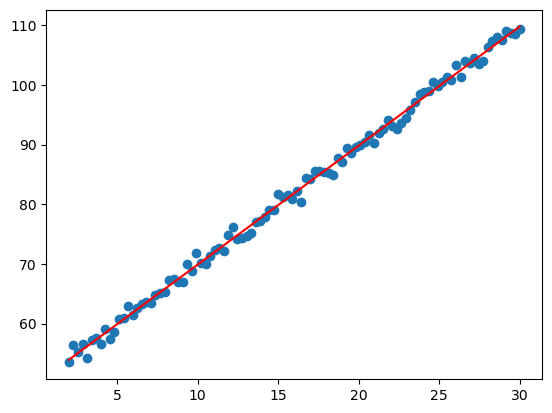

In [4]:
newx = np.stack((x, np.ones(x.shape[0])), axis=1).reshape(-1, 2)
k = np.linalg.inv(np.dot(newx.T, newx))
m = np.dot(k, np.dot(newx.T, y))
_ = plt.plot(x, y, "o")
_ = plt.plot(x, m[0] * x + m[1], "r")

4. Fit a linear ridge regression model to the data, and plot the predictions of the resulting model compared to the data.

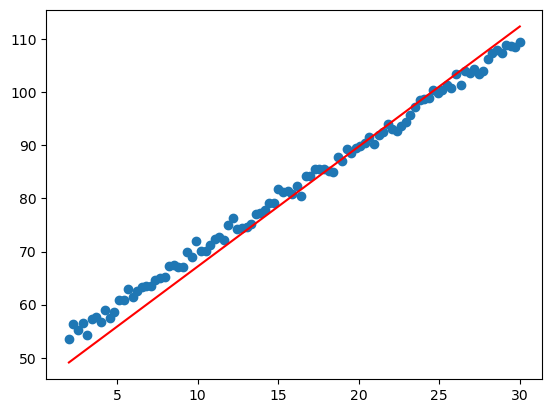

In [5]:
ridge_lambda = 2.5  # Excessive, just to show the effect!
k = np.linalg.inv(np.dot(newx.T, newx) + ridge_lambda * np.eye(newx.shape[1]))
m = np.dot(k, np.dot(newx.T, y))
_ = plt.plot(x, y, "o")
_ = plt.plot(x, m[0] * x + m[1], "r")

**Exercise 2: Kernel regression on *periodic* data**
1. The following dataset is given. Plot it.

In [6]:
xkr = np.linspace(2, 30, 100)
ykr = xkr + 4 * np.sin(xkr) + 4 * np.random.rand(xkr.shape[0])

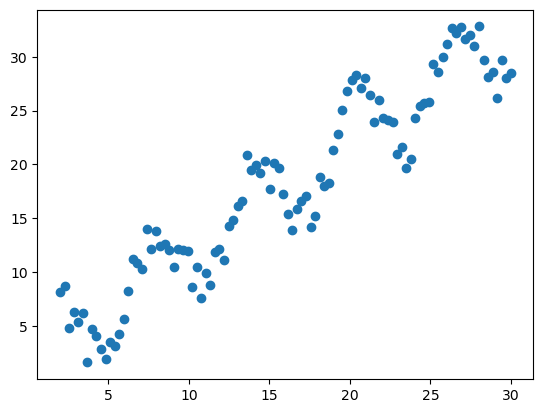

In [7]:
_ = plt.plot(xkr, ykr, "o")

2. Define a function that computes the Gaussian kernel value between two vectors, represented as numpy arrays.

In [8]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-(np.dot(x1 - x2, x1 - x2) / sigma**2))

3. With the fuction just defined, compute the Gram matrix of the dataset. Use a Gaussian kernel with $\sigma=1$.

In [9]:
kernel_sigma = 1
K = np.zeros((xkr.shape[0], xkr.shape[0]))
for i in range(xkr.shape[0]):
    for j in range(xkr.shape[0]):
        K[i, j] = gaussian_kernel(xkr[i], xkr[j], kernel_sigma)

4. Fit a kernel ridge regression model to the data, and plot the resulting model compared to the data.

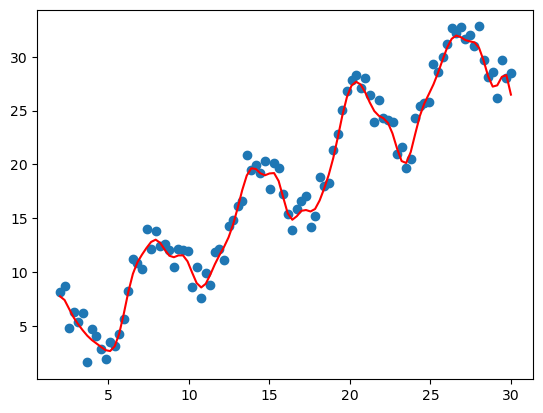

In [10]:
ridge_lambda = 0.1

a = np.linalg.inv(K + ridge_lambda * np.eye(K.shape[0]))
m = np.dot(ykr, a)

newx = np.stack((xkr, np.ones(xkr.shape[0])), axis=1).reshape(-1, 2)
yout = np.zeros(xkr.shape[0])

for i, x_p in enumerate(newx):
    k = np.zeros(xkr.shape[0])
    for j in range(xkr.shape[0]):
        k[j] = gaussian_kernel(x_p, newx[j, :], kernel_sigma)
    yout[i] = np.dot(m, k)

_ = plt.plot(xkr, ykr, "o")
_ = plt.plot(xkr, yout, "r")

### *Kernel PCA* and the *Radial Basis Function* (RBF) Kernel

Let us briefly recap the key concepts about PCA. We have a dataset $X\in R^{N\times d}$, and we want to find a new basis $Z\in R^{N\times d}$ such that the explained variance of the data, projected on the new basis, is maximized for any fixed number of components. This is equivalent to finding the eigenvectors of the covariance matrix $C=X^{T}X$.

Such operation requires the data to be centered, i.e. $X_{i}^{(j)}-\mu_{j} \rightarrow X_{i}^{(j)}$, where $\mu_{j}=\frac{1}{N}\sum_{i=1}^{N}X_{i}^{(j)}$ is the mean of the $j$-th feature.

We can also write the eigenvalue problem component-wise, as follows: $Cz_{j}=\lambda_{j}z_{j}$, where $z_{j}$ is the $j$-th eigenvector and $\lambda_{j}$ is the corresponding eigenvalue. The eigenvectors are orthogonal, i.e. $z_{j}^{T}z_{k}=0$ for $j\neq k$.

Moving to the kernelized case, we operate the substitution $x\rightarrow \phi(x)$, and the eigenvalue problem becomes $C_{K}v=\lambda v$ with $C_{K}=\frac{1}{N}\sum_{i}\phi(x_{i})\phi^{T}(x_{i})$, with $\phi(\cdot)$ being a generic feature map.

One can prove that solutions of the eigenvalue problem are in the form $v=\sum_{i}\alpha_{i}\phi(x_{i})$. Multiplying both sides of $C_{K}v=\lambda v$ by $\phi(x_{k})$ and substituting, we obtain $N\lambda \alpha=K \alpha$.

Such reasoning still requires normalization, i.e. $ \phi(x)-\frac{1}{d}\sum_{i}(\phi(x))_{i} \rightarrow \phi(x)$. The resulting kernel $K$ is in the form $K := K-2Id_{1/n}K + Id_{1/n}K Id_{1/n}$ with $Id_{1/n}$ the matrix with entries $1/n$.

A more thorough explanation can be found in [this blogpost](https://sdat.ir/en/sdat-blog/python-kernel-tricks-and-nonlinear-dimensionality-reduction-via-rbf-kernel-pca).


**Exercise 3: Kernel PCA**
1. A *Half Moons* dataset of $100$ points is given below. Plot it.

In [11]:
xhm, yhm = make_moons(n_samples=100, random_state=123)

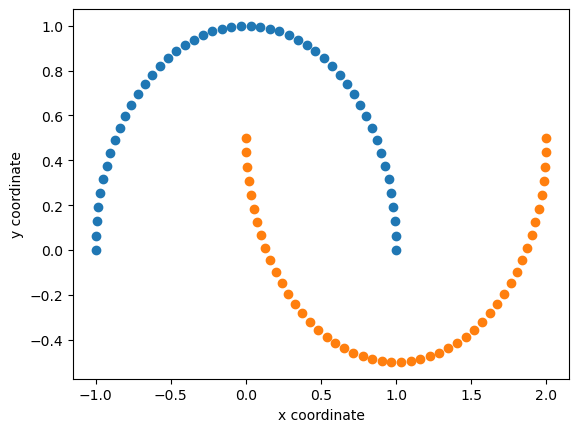

In [12]:
_ = plt.plot(xhm[yhm == 0, 0], xhm[yhm == 0, 1], "o")
_ = plt.plot(xhm[yhm == 1, 0], xhm[yhm == 1, 1], "o")
_ = plt.ylabel("y coordinate")
_ = plt.xlabel("x coordinate")

2. Apply the PCA algorithm to the dataset, and plot the resulting projection using the first 2 principal components.
**Hint**: you can use the `PCA` class from `sklearn.decomposition`.

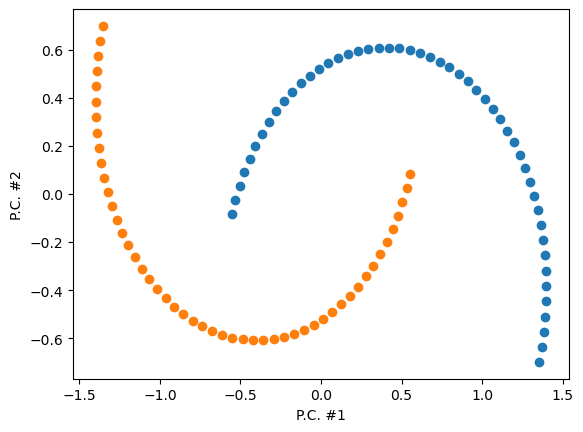

In [13]:
scikit_pca = PCA(n_components=2)
x_spca = scikit_pca.fit_transform(xhm)

_ = plt.plot(x_spca[yhm == 0, 0], x_spca[yhm == 0, 1], "o")
_ = plt.plot(x_spca[yhm == 1, 0], x_spca[yhm == 1, 1], "o")
_ = plt.xlabel("P.C. #1")
_ = plt.ylabel("P.C. #2")

3. Plot just the (projection on) first principal component. Comment on the separability of the two classes.

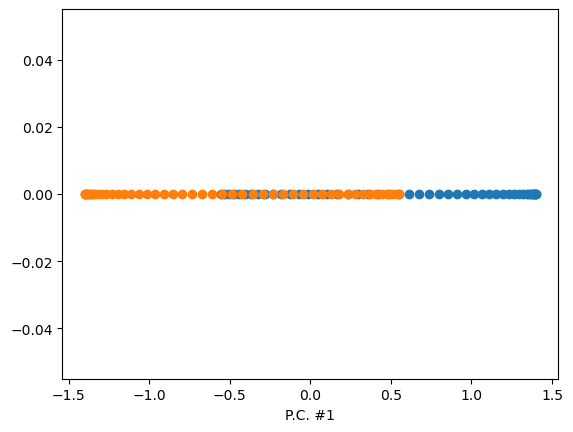

In [14]:
_ = plt.plot(x_spca[yhm == 0, 0], np.zeros([50, 1]), "o")
_ = plt.plot(x_spca[yhm == 1, 0], np.zeros([50, 1]), "o")
_ = plt.xlabel("P.C. #1")

4. Implement a function that computes the *Radial Basis* PCA algorithm of the dataset, given as a NumPy array.

In [15]:
def kpca(x_data, gamma, n_components):
    """
    Implementation of a RBF kernel PCA.

    Arguments:
        x_data: A MxN dataset as NumPy array where the samples are stored as rows (M),
           and the attributes defined as columns (N).
        gamma: The free parameter (coefficient) for the RBF kernel.
        n_components: The number of components to be returned.

    """

    # Compute the pairwise squared Euclidean distances across the dataset
    sq_dists = pdist(x_data, "sqeuclidean")

    # Convert pairwise distances into a square distances-matrix
    mat_sq_dists = squareform(sq_dists)

    # Compute the Gram matrix w.r.t. the RBF kernel
    K = exp(-gamma * mat_sq_dists)

    # Center the Gram matrix
    N = K.shape[0]
    ones_over_n = np.ones((N, N)) / N
    K = (
        K
        - ones_over_n.dot(K)
        - K.dot(ones_over_n)
        + ones_over_n.dot(K).dot(ones_over_n)
    )

    # Obtain the eigenpairs from the centered Gram matrix
    eigvals, eigvecs = LA.eigh(K)

    # Collect the top k eigenvectors (projected samples)
    xpcs = tuple(eigvecs[:, -istack] for istack in range(1, n_components + 1))
    xpcs = np.column_stack(xpcs)

    return xpcs

5. Apply the function just defined to the dataset, and plot the resulting projection using the first 2 principal components.

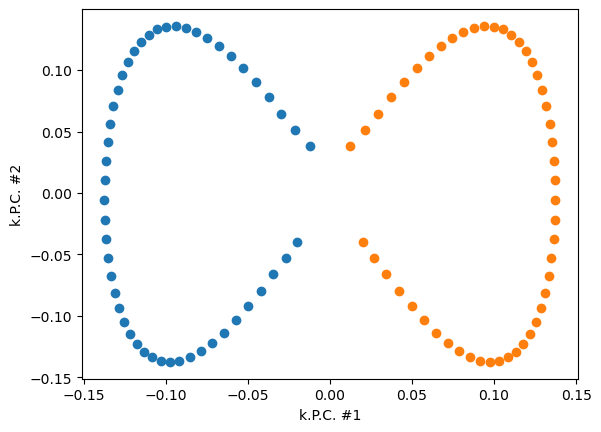

In [16]:
x_kpca = kpca(xhm, gamma=15, n_components=2)

_ = plt.plot(x_kpca[yhm == 0, 0], x_kpca[yhm == 0, 1], "o")
_ = plt.plot(x_kpca[yhm == 1, 0], x_kpca[yhm == 1, 1], "o")
_ = plt.xlabel("k.P.C. #1")
_ = plt.ylabel("k.P.C. #2")

6. Repeat the previous step, but plotting just the first principal component. Comment on the separability of the two classes.


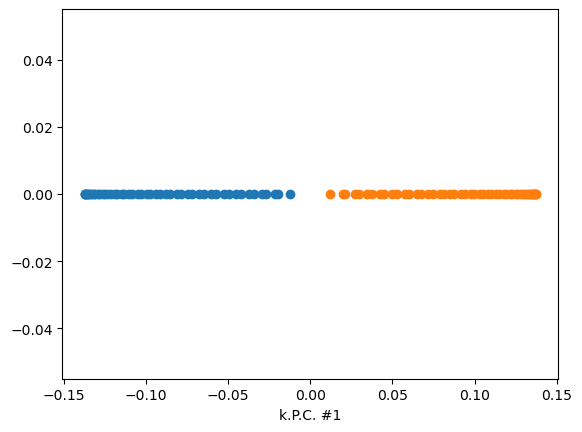

In [17]:
_ = plt.plot(x_kpca[yhm == 0, 0], np.zeros([50, 1]), "o")
_ = plt.plot(x_kpca[yhm == 1, 0], np.zeros([50, 1]), "o")
_ = plt.xlabel("k.P.C. #1")